# <center> Proteinus : package Python </center>
----------
![Logo mmsb](http://www.ibcp.fr/wp-content/uploads/2017/01/logo_MMSB_200.png "mmsb")![Lyon1](https://upload.wikimedia.org/wikipedia/en/thumb/d/d3/Claude_Bernard_University_Lyon_1_%28logo%29.svg/230px-Claude_Bernard_University_Lyon_1_%28logo%29.svg.png "Lyon1")

# Code Python
## Packages nécéssaires

In [1]:
import os
import sys
import requests
import xml.etree.ElementTree as XML
import shutil
import math
import re
import matplotlib.pyplot as plt

from termcolor import colored, cprint

Attention le (package WebLogo)[https://pypi.org/project/weblogo/] doit être installé sur la machine de travail. Il en va de même pour ClustalΩ (oméga).
Attention pour ClustalΩ, il est possible d’utiliser le script fourni par l’EBI (https://raw.githubusercontent.com/ebi-wp/webservice-clients/master/python/clustalo.py). Mais dans ce cas, son chemin doit être renseigné dans le `PATH` de la machine (à défaut de créer un alias), pour cela il suffit de modifier le *`bashrc`*.

### Modules pyproteinsExt et pyproteins

In [2]:
# module pyproteins & pyproteinsExt
#sys.path.append("/Users/aheurtel/Documents/Stage/pyproteins/src")
sys.path.append("/home/antoine/Documents/Stage2019/Stage/pyproteins/src")
#sys.path.append("/Users/aheurtel/Documents/Stage/pyproteinsExt/src")
sys.path.append("/home/antoine/Documents/Stage2019/Stage/pyproteinsExt/src")
sys.path
import pyproteinsExt.uniprot as uniprot
import pyproteinsExt.structure.coordinates as PDB
import pyproteins.sequence.msa as msaLib
import pyproteins.sequence.peptide as pep
import pyproteins.alignment.nw_custom as N
import pyproteins.alignment.scoringFunctions as scoringFunctions

### Variables globales nécessaires pour le bon fonctionnement du programme.
Attention à bien définir le répertoire de travail dans la variable `PATH`.

In [3]:
##                      GlobVAR
PATH = "/home/antoine/Documents/Stage2019/Protein/"
# Uniprot
FEAT = ['citation','clusters','comments','domains','domain','ec','id','entry name','existence',
        'families','features','genes','go','go-id','interactor','keywords','last-modified',
        'length','organism','organism-id','pathway','protein names','reviewed','sequence',
        '3d version','virus hosts']
#parameters commun of API (clustal and interpro)
MAIL = 'antoine.heurtel@ibcp.fr'
#WebLogo
#GlobVar pour WebLogo #list establised from https://www.uniprot.org/help/api_queries
TITLE = 'WebLogo'
LABEL = ''
LEN = 40
DPI = 400
START = 1
BOX = 'yes'
COLOR = 'chemistry'

### Fonctions
Définitions des fonctions du programme.

In [4]:
def uniprotInfo(prot, element='', echo = False, xml = False, name = 'uniprot.xml', path = ''):
    """
    Information retrieval from UniProt in format xml or text.
    prot is the code accession protein
    element (optional) of list FEAT
    echo if you want verbose mode
    xml if you want download and save a xml file from UniProt
    name is the outname file
    path (optional) path to save result
    Return : text if echo is true
    """
    if xml:
        if os.path.exists(PATH+prot+'Data/'+name):
            print('file {} already exist, please select a other name.'.format(name))
            return True
        else:
            try:
                f = open(path+name, 'w')
            except FileNotFoundError:
                path = input('Please enter the folder to save your data : ')
                if not path[-1] == '/':
                    path += '/'
                f = open(path+name, 'w')
            webpage = requests.get('https://www.uniprot.org/uniprot/'+prot+'.xml')
            f.write(webpage.text)
            f.close()
            return None
    for i in element:
        if i not in FEAT:
            print("L' element "+str(i)+" n'est pas reconnu.")
            print("Choisissez parmi : "+str(FEAT))
        #a faire verif protéine existe
        PROTEIN = prot
        col = ''
        #faire la possibilité ou a est vide if a !='':INFO = '&columns='+INFO
        for i in element:
            col += i+','
        INFO = '&columns='+col[:-1]
        URL = "https://www.uniprot.org/uniprot/?query="+PROTEIN+"&format=tab"+INFO
        print('from '+URL)
        web = requests.get(URL)
        if echo:
            print(web.text)
            return None
        else:
            return(web.text)
        
def makeURL(element,prot):
    '''
    make an url adress for RESET UniProt
    elemes is in FEAT
    prot is code accession protein
    RETURN : tuple
    '''
    for i in element:
        if i not in FEAT:
            print("L' element "+str(i)+" n'est pas reconnu.")
            print("Choisissez parmi : "+str(FEAT))
    #a faire verif protéine existe
    PROTEIN = prot
    col = ''
    #faire la possibilité ou a est vide if a !='':INFO = '&columns='+INFO
    for i in element:
        col += i+','
    INFO = '&columns='+col[:-1]
    URL = "https://www.uniprot.org/uniprot/?query="+PROTEIN+"&format=tab"+INFO
    return(URL,PROTEIN)

def makeDirectory(name):
    if not os.path.exists(PATH+name):
        os.makedirs(PATH+name+'/Data/')
    if not os.path.exists(PATH+name+'/Data/WebLogo'):
        os.makedirs(PATH+name+'/Data/WebLogo')
    return True

def verifSeq(name):
    return os.path.exists(PATH+name+'/Data/sequence')

def writeFile(file, text, path = None):
    """
    write a text in file in path… Of course, if the file doesn’t exist…
    """
    if os.path.exists(path+file) or os.path.exists(path+'/'+file):
        print('already exist')
        return False
    else:
        f = open(path+file,'w')
        f.write(text)
        f.close()

def verifFile(file, path=''):
    """
    Test File existance
    RETURN : bool
    """
    if not file:
        return False
    
    m = re.findall('([^\.]+)',file)
    if not m:
        raise ValueError
        print("filename incorrect "+ValueError)
    filename = ".".join(m[:-1])
    ext = m[-1]
    if os.path.exists(path+filename) or os.path.exists(path+'/'+filename):
        return True
    
    elif os.path.exists(path+filename+ext) or os.path.exists(path+'/'+filename+ext) or os.path.exists(path+'/'+filename+'.'+ext):
        return True
    
    else:
        return False

def sequenceUniprot(prot):
    '''
    download protein sequence from uniprot
    RETURN : string
    '''
    url = makeURL(['sequence'],prot)
    web = requests.get(url[0])#faire un try
    return(web.text.split('\n')[1])

def compar(a,b,c=None):
    """
    comparaison between 2 or 3 letters (AA)
    RETURN : bool
    """
    if not c:
        if a.upper() == b.upper():
            return True
    else:
        if a.upper() == b.upper() == c.upper():
            return True
    return False

def legende():
    """
    Make a legend for intersection between chiméra and PDB
    NB : legend is used by matplot so legende 
    """
    print("\n")
    print(colored(" ", 'white', 'on_green'),"  perfect Match",)
    print(colored(" ", 'white', 'on_yellow'),"  PDB Match")
    print(colored(" ", 'white', 'on_blue'),"  PDB & Chimera Match, no UniProt")
    print(colored(" ", 'white', 'on_red'),"  No Match")

def intersection(protSeq, pdbFile, pdbChimeraFile, verbose="True"):
    """
    Display match between PDB file and protein sequence
    pdbFile preferentialy from bnaq of pdb like rcsb.org so his extension is .pdb
    pdbChimeraFile preferentialy from a selection of chimera, his extension is txt
    Return dictionary of differents match
    """
    #import pyproteinsExt.structure.coordinates as PDB
    #Step PDB
    parser = PDB.Parser()
    pdbObj = parser.load(file=pdbFile)
    AApdb = [(pep.threeToOne(aa.name), int(aa.num)) for aa in pdbObj.byres()]
    #Step Chimera
    f = open(pdbChimeraFile, 'r')
    AAchimera = []
    for line in f.readlines():
        elements = re.search('^#0.1.(?!.*HOH|.*MG).*',line)
        if elements:
            m = elements.string.split(" ")
            AAchimera.append((pep.threeToOne(m[1]), int(m[2].strip().split(".")[0])))
            #print(m[1]+" at "+str(pos[0]))
    #print(AAchimera)
    """i = 0
    for pos,aa in enumerate(P04483.seq):
        if aa == AAchimera[i][0] and pos == AAchimera[i][1]:
            text = colored(aa,'white', 'on_green')
            i += 1
        if aa == AAchimera[i][0]:
            text = colored(aa,'white', 'on_blue')
            i += 1
        else:
            text = colored(aa, 'yellow')
        print(text, end='')"""
    d = {}
    # Attention numérotation informatique pour Uniprot mais numérotation naturelle pour les pdb
    for pos, aa in enumerate(protSeq):
        if pos not in d:
            d[pos] = [aa]
    for aa1, pos1 in AApdb:
        d[pos1-1].append(aa1.lower())
    for aa2, pos2 in AAchimera:
        d[pos2-1].append(aa2)
    #Step printer
    #1 UniProt ; lower PDB ; 3 Chiméra (upper)
    result = {"red":[], "green":[], "yellow":[], "blue":[]}
    for pos in d:
        #len 1
        if len(d[pos]) == 1:
            text = d[pos][0].lower()
        #len 2
        elif len(d[pos]) == 2:
            if compar (d[pos][0], d[pos][1]):
                if d[pos][1].isupper():
                    text = colored(d[pos][0], 'white', 'on_green')
                    result["green"].append((d[pos][0],pos))
                else:
                    text = colored(d[pos][0], 'grey', 'on_yellow')
                    result["yellow"].append((d[pos][0],pos))
            else:
                text = colored(d[pos][0], 'grey', 'on_red')
                result["red"].append((d[pos][0],pos))
        #len 3
        elif len(d[pos]) == 3:
            #3 match
            if compar(d[pos][0], d[pos][1], d[pos][2]):
                #le [2] est chimera
                text = colored(d[pos][0], 'grey', 'on_green')
                result["green"].append((d[pos][0],pos))
            #2 match
            #PDB & Uniprot
            elif compar(d[pos][0], d[pos][1]):
                if d[pos][1].islower():
                    text = colored(d[pos][0], 'grey', 'on_yellow')
                    result["yellow"].append((d[pos][0],pos))
                else:
                    text = colored(d[pos][0], 'grey', 'on_green')
                    result["green"].append((d[pos][0],pos))
            #chimera & Uniprot
            elif compar(d[pos][0], d[pos][2]):
                text = colored(d[pos][0], 'grey', 'on_green')
                result["green"].append((d[pos][0],pos))
            #chimera & PDB
            elif compar(d[pos][1], d[pos][2]):
                text = colored(d[pos][0], 'grey', 'on_blue')
                result["blue"].append((d[pos][0],pos))
            #NO match
            else:
                text = colored(d[pos][0], 'white', 'on_red')
                result["red"].append((d[pos][0],pos))
        print(text, end='')
    legende()
    if verbose:
        print(result["green"])
        print(result["blue"])
    return result

## POO
Définition de l'objet *protein*

In [5]:
class Protein:
    def __init__(self, name):
        '''
        name = protein code accession
        '''
        #self.id = name #on peut créer une fct de vérif de nom
        #self.name = ''
        self.name = name
        if makeDirectory(name):
            self.pwd = PATH+name+'/Data/'
        if not verifSeq(name):
            print('Download uniprot.xml')
            uniprotInfo(name, xml = True, name = 'uniprot.xml', path=self.pwd)
            """
            print('Download sequence')
            sequence = uniprotInfo(name, ['sequence'])# name = protein code uniprot
            self.name = name
            self.seq = sequence
            writeFile('sequence', sequence, PATH+name+'/Data/')
            """
        uniprotColl = uniprot.getUniprotCollection()
        uniprotColl.setCache(location=self.pwd)
        #uniprot.getPfamCollection().setCache(location=self.pwd)
        self.uniprot = uniprotColl.get(name)
        self.seq = self.uniprot.fasta.split('\n')[1]
        self.domains = {}
        self.blastFile = None
        self.homologyFile = None
    
    def scanDomains(self):
        '''
        parsing domains.tsv from interproScan
        RETURN : nothing
        WRITE in self.domains : key = domain's description a dict with multi keys : name = ID and interval = tuple (Strat, Stop)
        '''
        if len(self.domains) > 0:
            print('scan has done')
            return True
        try:
            print('step 1/2 : searching domains')
            self.domains = open(self.pwd+'domains.tsv','r')
            self.domains.close()
        except IndexError as error:
            print(error)
        except FileNotFoundError:
            url = 'https://www.ebi.ac.uk/interpro/protein/'+self.name+'?export=tsv'
            domainsWeb = requests.get(url)
            codeError = domainsWeb.status_code
            if codeError != 503 or int(codeError/100) != 5 or int(codeError/100) != 4:
                print('Downloading from Uniprot')
                f = open(self.pwd+'domains.tsv', 'w')
                f.write(domainsWeb.text)
                f.close()
            else:
                print('Submitted domains to InterProScan...')
                #parameters for REST InterProScan
                mail = 'antoine.heurtel@ibcp.fr'
                out = self.pwd+'domains'
                ext = 'tsv'
                fasta = self.pwd+'sequence'
                cmd = "python iprscan.py --email "+mail+" --outfile="+out+" --outformat="+ext+" "+fasta
                os.system(cmd)
                os.rename(self.pwd+'domains.tsv.txt', self.pwd+'domains.tsv')
            print('step 2/2 : scanning')
        #Parser
        finally:
            with open(self.pwd+'domains.tsv','r') as domains:
                self.domains = {}
                for lines in domains.readlines():
                    col = lines.split('\t')
                    if col[0] == '':
                        break
                    elif col[0] == 'Protein Accession':
                        pass
                    else:
                        try:
                            #name = col[4]
                            description = col[12]
                            if description == None or description == '':
                                description = col[4]
                        except IndexError:
                            break
                        if description not in self.domains.keys():
                            #self.domains[name] = {} #initname
                            #self.domains[name]['interval'] = []
                            self.domains[description] = {} #initname
                            self.domains[description]['interval'] = []
                        try:
                            #self.domains[name]['is'] = col[12]
                            self.domains[description]['name'] = col[4]
                        except IndexError:
                            #self.domains[name]['is'] = 'NA'
                            description = 'NA'
                            self.domains[description]['name'] = col[4]
                        interval = (col[6],col[7])
                        #self.domains[name]['interval'].append(interval)
                        self.domains[description]['interval'].append(interval)
            print('scanning finish')
            
    def blast(self):
        """
        TO DO
        *Do. Or not do. There is no try…*
        """
       #DEBUG
        print('DEBUG MODE\tBLAST : DISABLED')
        if os.path.exists(self.pwd+'blast.xml'):
            self.blastFile = self.pwd+'blast.xml'
            if not self.blastFile:
                print('WARNING :\tNO BLAST FILE FOUND')
                return False
            else:
                print('DEBUG MODE\tHOMOLOGY FILE : '+self.blastFile)
            return True
        #END DEBUG
        #submited to BLAST : TO DO
    
    def homology(self, name='homology.fasta'):
        """
        Parsing blast.xml to save the sequences in fasta
        RETURN : nothing
        WRITE in self.homologyFile a string of path to fasta file
        """
        if verifFile(self.homologyFile):
            return True
        if verifFile(name, path=self.pwd):
            print('WARNING :\tFile already exist')
            self.homologyFile = self.pwd+name
            return True
        if not verifFile(self.blastFile):
            #self.blast()
            if not self.homologyFile and not self.blast():
                print('ERROR :\tBlast file is missing')
                print("SCRIPT STOP")
                sys.exit()
        tree = XML.parse(self.blastFile)
        root = tree.getroot()
        self.seqhomology = {}
        for hit in root.iter('Hit'):
            self.seqhomology[hit[3].text] = hit[5][0][15].text
        if name.split('.')[-1] != 'fasta':
            name += '.fasta'
        nbr = len(root[8][0][4])
        count = 1
        end = False
        with open(self.pwd+name, 'w') as f:
            for id in self.seqhomology.keys():
                if id == self.name:
                    end = True
                sys.stdout.write('Downloading %s sequence %s /%s \r' % (id, count, nbr))
                sys.stdout.flush()
                f.write('>'+id+'\n')
                seq = sequenceUniprot(id)
                f.write(seq+'\n')
                count += 1
            if not end:
                id = self.name
                sys.stdout.write('Add %s master sequence %s /%s \r' % (id, count, nbr))
                sys.stdout.flush()
                seq = sequenceUniprot(id)
                f.write('>'+id+'\n'+seq+'\n')
            self.homologyFile = self.pwd+name
            print('\nfile '+self.homologyFile+' created')

    def clustal(self, out='', fasta=''):
        """
        Do a multi sequence alignement with ClustalΩ (clustalo.py)
        out name of clustal file to write
        fasta is the homoly sequence fasta
        RETURN : nothing
        WRITE : self.clustalFile a string of path to clustal file
        WARNING : clustalo must be executing with PYTHON 3 !
        """
        #default choice
        if fasta == '':
            if self.homologyFile == None:
                self.homology()
            fasta = self.homologyFile
        if out == '':
            if verifFile('alignements.aln', path = self.pwd) and verifFile('alignements.clustal', path = self.pwd):
                print("WARNING : Clustal's file already exist")
                self.clustalFile = self.pwd+'alignements.aln'
                return True
        #custom
        if verifFile(fasta) and out != '':
            if verifFile(out, path = self.pwd):
                print("WARNING : Clustal's file already exist")
                self.clustalFile = self.pwd+out
                return True
        else:
            ('ERROR :\tFasta file not found')
        #alignements
        print('Alignements with Clustal omega')
        #parameters for REST InterProScan
        ext = ' --outformat=aln-clustal_num'
        if out == '':
            #cmd = "python3 clustalo.py --email "+MAIL+\ or
            #cmd = "python clustalo.py --email "+MAIL+\ or
            cmd = "clustalo.py --email "+MAIL+\
            " --outfile="+self.pwd+'alignements'+' '+ext+' '+fasta
            filename = self.pwd+'alignements'
        else:
            cmd = "clustalo.py --email "+MAIL+\
            " --outfile="+self.pwd+out+' '+ext+' '+fasta
            filename = self.pwd+out
        print(cmd)
        os.system(str(cmd))
        os.rename(filename+'.aln-clustal_num.clustal_num',filename+'.clustal')
        print('rename : {} in {}'.format(filename+'.aln-clustal_num.clustal_num',filename+'.clustal'))
        shutil.copyfile(filename+'.clustal', filename+'.aln')
        self.clustalFile = filename+'.aln'
    
    def WebLogo(self, paramCustom, start=START, stop=0, label='', nameOut='WebLogo.png'):
        """
        Do a weblogo with weblogo package
        RETURN : nothing
        """
        if paramCustom:
            paramWebLogo()
        if not os.path.exists(self.clustalFile):
            try:
                print(self.clustalFile)
            except:
                print("No clustal file")
            print("Doesn't found clustal file, program just stop")
            sys.exit()
        if stop == 0:
            stop = ' '
        else:
            stop = ' -u '+str(stop)
        outfile = self.pwd+'WebLogo/'+nameOut
        if not label == '':
            label = " --label "+str(label)
        cmd = 'weblogo --format PNG -f '+self.clustalFile+\
        ' -D clustal -A protein -s large -t '+TITLE+' -n '+str(LEN)+\
        ' -l '+str(start)+stop+' --stack-width 20 --aspect-ratio 8 --box '+BOX+\
        ' --resolution '+str(DPI)+' --show-ends yes -c '+COLOR+' '+label+\
        ' --composition none -o '+outfile
        if os.path.exists(outfile):
            print(outfile+'\nWARNING :\tFile already exist\n')
        else:
            os.system(cmd)
        #print("ERROR :\t "+cmd)
    
    def domains2WebLogo(self, domain=None):
        """
        Do a weblogo with interval from domains
        """
        if domain == None:
            self.scanDomains()
            for domID in self.domains:
                #LABEL = self.domains[domID]['is'].replace(' ','_')
                mini = len(self.seq)
                maxi = 0
                for i in self.domains[domID]['interval']:
                    if int(i[0]) < int(mini) : mini = i[0]
                    if int(i[1]) > int(maxi) : maxi = i[1]
                out = domID.replace(' ','_')+'-'+str(mini)+'-'+str(maxi)+'.png'
                print(out)
                LABEL = domID.replace(' ','_')
                self.WebLogo(False, start = mini, stop = maxi,label = LABEL, nameOut = out)
        elif domain in self.domains:
            mini = self.domains[domain]['interval'][0]
            maxi = self.domains[domain]['interval'][1]
            out = domID.replace(' ','_')+'-'+str(mini)+'-'+str(maxi)+'.png'
            print(out)
            LABEL = domain.replace(' ','_')
            self.WebLogo(False, start = mini, stop = maxi,label = LABEL, nameOut = out)
        else:
            print('No domains is informed.\n So, ToDo to a student...')
        print("\tThat'all ✔\n")
    
    def msa(self, verbose = False, maxLen = 500):
        """
        do a multi sequence alignement with pyproteins library
        calculation of entropy shannon
        """
        def f(d):
            return d["index"] < maxLen
        def g(d):
            return re.search(self.name, d["record"]['header'])
        def searchIndex(name):
            STOP = False
            i = 0
            while not STOP:
                if oMsa[i]['header'] == name:
                    STOP = True
                    return i
                i += 1
                
        oMsa = msaLib.Msa(fileName=self.clustalFile)
        #oMsa.maskMaster(self, masterIndex=0)
        #sequence strip gap
        index = searchIndex(self.name)
        print("Index sequence master is "+str(index))
        oMsa = oMsa.maskMaster(masterIndex=index)
        recordList = oMsa.recordLookup(predicate=f)
        nbrSeqTot = len(oMsa)
        nbrSeqStudy = len(recordList)
        score = {}
        LEN = oMsa.shape[1]
        for msa in oMsa:
            for col,AA in enumerate(msa['seq']):
                if col not in score.keys():
                    score[col] = {}
                if AA not in score[col].keys():
                    score[col][AA] = 1
                else:
                    score[col][AA] += 1
        entropyShannon = []
        entropyHeight = []
        height = []
        SH = 0
        e = (1 / math.log(2)) * (19 / (2 * LEN))
        for col in score.keys():
            for AA in score[col].keys():
                freq = score[col][AA] / nbrSeqStudy
                H = 0 - freq * math.log(freq)
                SH += H
                R = math.log2(20) - (SH + e)
                height.append(R*freq)
                if verbose:
                    print(f"pos  {col+1} is {AA}   {score[col][AA]} / {nbrSeqStudy} = {freq} with height : {R*freq}")
            if verbose:
                print(f"\t\t\tentropy = {SH}  with height = {max(height)}")
            entropyShannon.append(SH)
            entropyHeight.append(max(height))
            SH = 0
            height = []
        self.entropy = entropyShannon
        self.entropyHeight = entropyHeight

# Exemple d'application
Prenons comme exemple la protéine **P04483** qui est la *Tetracycline repressor protein class B from transposon Tn10*[1].
## Initialisation
Avant d'accéder aux informations de la protéine, il est important d'initialiser le programme en lui précisant le nom de la protéine d'intérêt.  
D'un point de vue informatique, il s'agit en la création d'un objet python. Cet objet peut porter n'importe quel nom.  
Par exemple avec le nom `protein` la commande est : `protein =  protein(name = 'P04483')`

In [6]:
P04483 = Protein(name = 'P04483')

Download uniprot.xml
Acknowledged 0 entries (/home/antoine)
Changing cache location to /home/antoine/Documents/Stage2019/Protein/P04483/Data/
Reindexing /home/antoine/Documents/Stage2019/Protein/P04483/Data/
Acknowledged 0 entries (/home/antoine/Documents/Stage2019/Protein/P04483/Data/)
got to fetch P04483


Une fois l'initialisation faite, nous pouvons récupérer plusieurs information sur la protéine. Ces informations proviennent de la base de données [Uniprot](https://www.uniprot.org), mais aussi de l'API d'InterproScan[] et ... .

Il existe deux façons de récupérer ces informations :
- soit en récupérer un fichier xml contenant toutes les informations de la fiche uniprot
- soit au cas par cas

### Fichier xml
Il est possible de récupérer sous forme de fichiezr xml toutes les informations de la fiche uniprot de la protéine via la commande : `uniprot(protein, xml=True)`, où *protein* correspond à l'identifiant uniprot de la protéine d'intérêt.

### Cas par cas
Il est possible pour l'utilisateur d'obtenir directement en ligne de commandes une partie des informations disponible sur la protéine à partir de la fiche uniprot. Ceci sans nécéssairement créer un objet python. Par exemple les informations suivantes sont directement accessible par simple lignes de commandes :
- la séquence protéique
- son id
- l'organisme(s) dans le(s)quelle(s) la protéine est présente
- etc. (cf variable FEAT du GlobVar)

In [7]:
#Séquence protéique :
uniprotInfo('P04483', ['sequence'], echo=True)
#ID
uniprotInfo('P04483', ['id'])
#organisme
uniprotInfo('P04483', ['organism','citation'], echo=True)

from https://www.uniprot.org/uniprot/?query=P04483&format=tab&columns=sequence
Sequence
MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS

from https://www.uniprot.org/uniprot/?query=P04483&format=tab&columns=id
from https://www.uniprot.org/uniprot/?query=P04483&format=tab&columns=organism,citation
Organism	PubMed ID
Escherichia coli	6330687; 3208760; 6311683; 3062183



## Objet *protein* de Pyhton
Les informations suivantes sont accessible en python si l'objet protein a été initié :
* la séquence
* le répertoire des données
* les domaines d'intérêts

## Séquence protéique
Pour obtenir la séquence il suffit de taper

In [8]:
P04483.seq

'MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS'

## Sites et domaines protéiques
Proteinus est capable de soumettre une séquence protéique au programme d'InterProScan, dans le but de récupérer des informations concernant des domaines protéiques fonctionnelles.

À l'issue de l'éxécution de ce programme le fichier de sortie d'InterProScan est stocké dans le dossier `Data`de la protéine sous le nom de `domain.tsv`.
Proteinus va ensuite parser le fichier de sortie dans le but de récupérer les informations suivantes, qui seront ajouté à l'objet `protein` précédement créé.

Les commandes suivantes permettent de soumettre la séquence protéique à InterProScan puis à pouvoir accéder à ces résultats.

In [9]:
P04483.scanDomains()

step 1/2 : searching domains
step 2/2 : scanning
scanning finish


La commande suivante permet de visualiser le résultat du parser.

In [10]:
P04483.domains

{'DNA-binding HTH domain, TetR-type, conserved site': {'interval': [('21',
    '52')],
  'name': 'PS01081'},
 'DNA-binding HTH domain, TetR-type': {'interval': [('10', '55'),
   ('30', '53'),
   ('9', '22'),
   ('3', '63')],
  'name': 'PS50977'},
 'Tetracycline repressor TetR, C-terminal': {'interval': [('69', '201')],
  'name': 'PF02909'},
 'Tetracycline transcriptional regulator, TetR': {'interval': [('21', '44'),
   ('130', '149'),
   ('95', '118'),
   ('183', '197'),
   ('75', '94')],
  'name': 'PR00400'},
 'Homeobox-like domain superfamily': {'interval': [('5', '67')],
  'name': 'SSF46689'},
 'Tetracyclin repressor-like, C-terminal domain superfamily': {'interval': [('69',
    '204')],
  'name': 'SSF48498'},
 'G3DSA:1.10.10.60': {'interval': [('1', '66')], 'name': 'G3DSA:1.10.10.60'},
 'G3DSA:1.10.357.10': {'interval': [('67', '203')],
  'name': 'G3DSA:1.10.357.10'}}

Le résulatat de cette commande nous retourne un dictionnaire de dictionnaires Python. La première clef correspond à la description du nom de la signature trouvée. Si aucune description n'est donnée alors lcette clef devient le nom de la signature.
On peut par la suite accéder aux informations liées à cette signature via la commande suivante.

In [11]:
P04483.domains['DNA-binding HTH domain, TetR-type, conserved site']

{'interval': [('21', '52')], 'name': 'PS01081'}

On remarque que la clef `PR00455` est associée à un dictionnaire contenant l'intervalle (sous forme de tuple) du ou des domaines ; ainsi que la description succincte de ce domaine 'sous forme de chaîne de caractères).

Pour avoir les positions de début et de fin de ce domaine on utilise la commande suivante. Attention, si plusieurs domaines sont associés, alors il y auraplusieurs intervalles qui seront retournés.

In [12]:
P04483.domains['DNA-binding HTH domain, TetR-type']['interval']

[('10', '55'), ('30', '53'), ('9', '22'), ('3', '63')]

## Recherche de séquences homologues
### ~~BLAST~~
TO DO BLAST
Il est possible de télécharger le résultat de blast sous forme de fichier xml et de l'enregistrer dans le dossier `Data` de la protéine. Proteinus est capable de détecter la présence ou non d'un fichier xml.
### Parser fichier xml de blast
Proteinus est capable de parser un fichier blast pour en extraire les alignements des séquences homologues.
Ces alignements sont ensuites enregistés dans l'objet `protein` de la protéine, comme illustré par les commandes suivantes.

La méthode `homology`est responsable du parser du fichier xml, si celui est présent. Dans le cas contraire cette méthode fera appel à la méthode `blast`pour pouvoir exécuter un blast et ainsi récupére le fichier xml.

In [13]:
P04483.homology()

DEBUG MODE	BLAST : DISABLED
ERROR :	Blast file is missing
SCRIPT STOP


SystemExit: 

/home/antoine/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
#Ajout d’un fichier Blast (blast.xml)
P04483.homology()

DEBUG MODE	BLAST : DISABLED
DEBUG MODE	HOMOLOGY FILE : /home/antoine/Documents/Stage2019/Protein/P04483/Data/blast.xml
file /home/antoine/Documents/Stage2019/Protein/P04483/Data/homology.fasta created


Il est possible d'accéder aux alignement qui sont rangés dans un dictionnaire de l'objet

## Alignements multiples
L'alignement des séquences homologues précédement trouvées s'effectuera avec clustal oméga en ligne de commende via un script pythion récupéré depuis les sources du projet de l'EBI.
Ceci nous permettra de visualiser des régions conservées. De plus, il sera possible de croiser les positions des domaines prédits précédements.

La commande suivante permet de réaliser un alignement multiple sur les séquences homologues si cella n'a pas été fait précédement.

L'ordre des paramètres optionels est le suivant :
1. un suffix (optionnel) pour le fichier de sortie
2. le fichier fasta contenant les séquences homologues (dont notre séquence maîtressse) : par défaut le nom de ce fichier est enregistré dans un atribut de l'objet python.

In [14]:
P04483.clustal()

Alignements with Clustal omega
clustalo.py --email antoine.heurtel@ibcp.fr --outfile=/home/antoine/Documents/Stage2019/Protein/P04483/Data/alignements  --outformat=aln-clustal_num /home/antoine/Documents/Stage2019/Protein/P04483/Data/homology.fasta
rename : /home/antoine/Documents/Stage2019/Protein/P04483/Data/alignements.aln-clustal_num.clustal_num in /home/antoine/Documents/Stage2019/Protein/P04483/Data/alignements.clustal


En sortie, nous obtenons 2 fichiers identiques. Seule l'extension de ces fichiers varie. La première est `.clustal`, extension “conventionnelle“. La seconde est `.aln`, extension personnalisée qui sera reconnu par la suite du programme, notament par la librairie [*pyproteinsExt*](https://github.com/glaunay/pyproteinsExt/blob/master/src/pyproteinsExt/notebooks/HMMR_wrapper.ipynb), permettant de parser des fichiers d'alignements multiples.
Dans les deux cas les fichiers sont au format clustal oméga.

## WebLogo
### Visualisation
La visualisation des sites conservés peut se faire avec WebLogo.

Il y a deux façon de procédés.

La première est d'utiliser la méthode `WebLogo`. Cette méthode permet de visualiser le WebLogo du premier acide aminé jusqu'à l'acide aminé *n* (paramètre *STOP*) de la protéine.
La commande est : `self.WebLogo(paramCustom, STOP=0, nameOut='WebLogo.png')` avec `paramCustom`une variable booléen qui permet d'utiliser WebLogo avec des paramètres personnalisés. `STOP`désigne la position du dernier acide aminé de la protéine à visualiser, par défaut ce paramètre vaut 0 et sera interprétécomme étant le dernier de la protéine.

In [15]:
P04483.WebLogo(False, stop=66, nameOut='WebLogo.png')

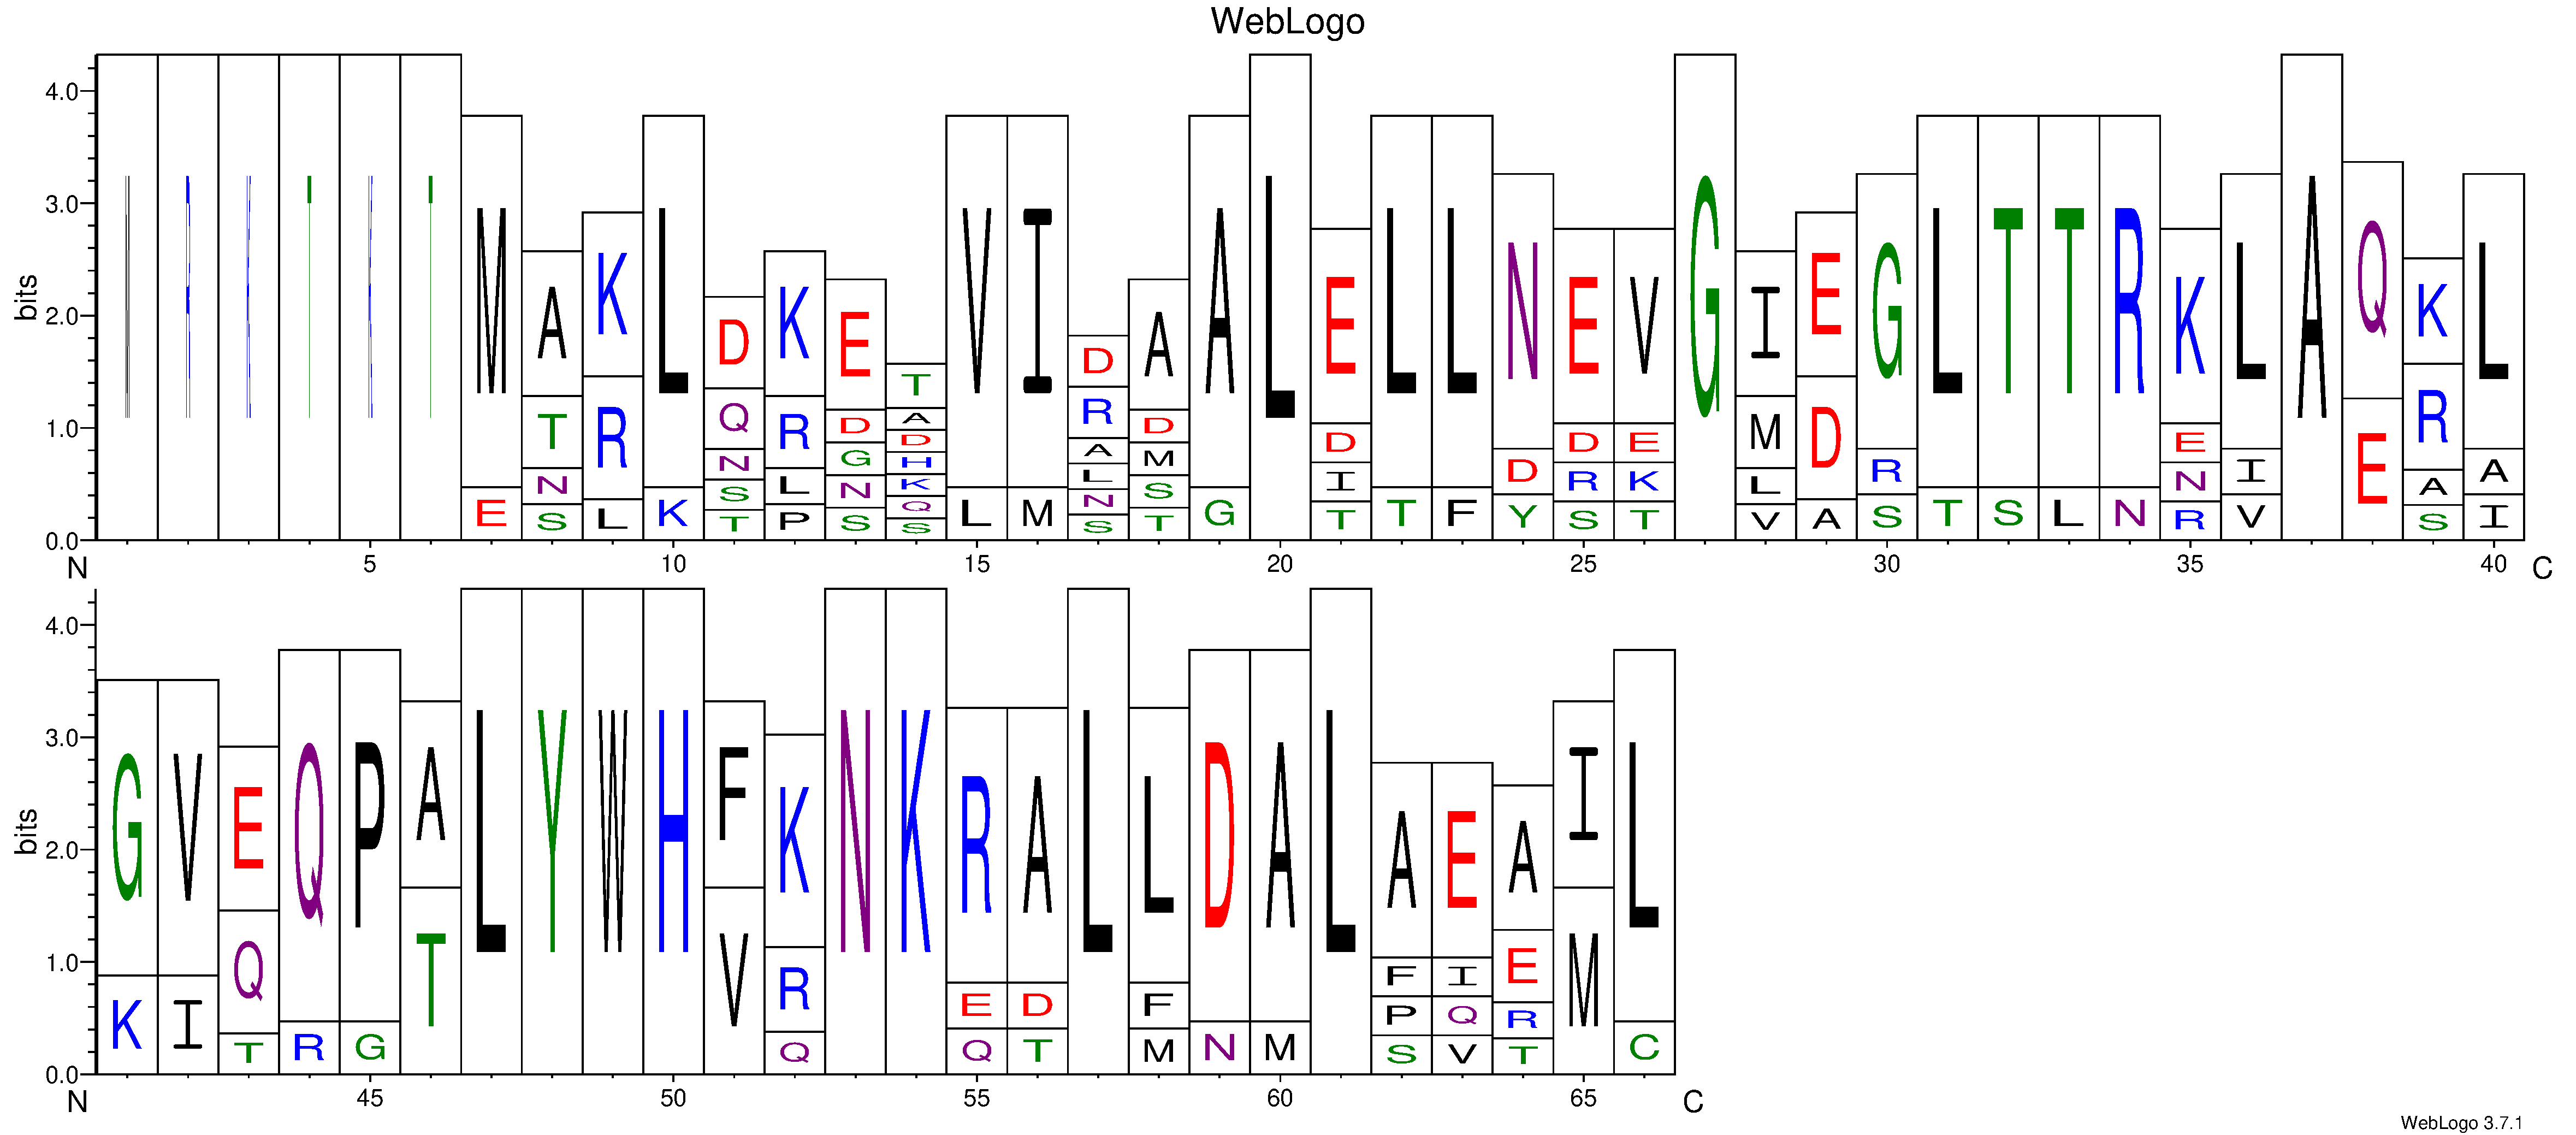

La seconde méthode est celle de restreindre l'intervalle de visualisation du WebLogo en se concentrant uniquement sur les domaines précédement enregistrés. On peut choisir de sélectionner un domaine en particulier ou non.

La commande est la suivante :
    `self.domains2WebLogo(self, domain=None)` avec `domain` le nom du domaine d'intérêt par défaut (*None*), le programme lira tous les domaines de la protéine.

In [16]:
P04483.domains2WebLogo()

scan has done
DNA-binding_HTH_domain,_TetR-type,_conserved_site-21-52.png
DNA-binding_HTH_domain,_TetR-type-3-63.png
/home/antoine/Documents/Stage2019/Protein/P04483/Data/WebLogo/DNA-binding_HTH_domain,_TetR-type-3-63.png

Tetracycline_repressor_TetR,_C-terminal-69-201.png
Tetracycline_transcriptional_regulator,_TetR-21-197.png
Homeobox-like_domain_superfamily-5-67.png
Tetracyclin_repressor-like,_C-terminal_domain_superfamily-69-204.png
G3DSA:1.10.10.60-1-66.png
G3DSA:1.10.357.10-67-203.png
That'all


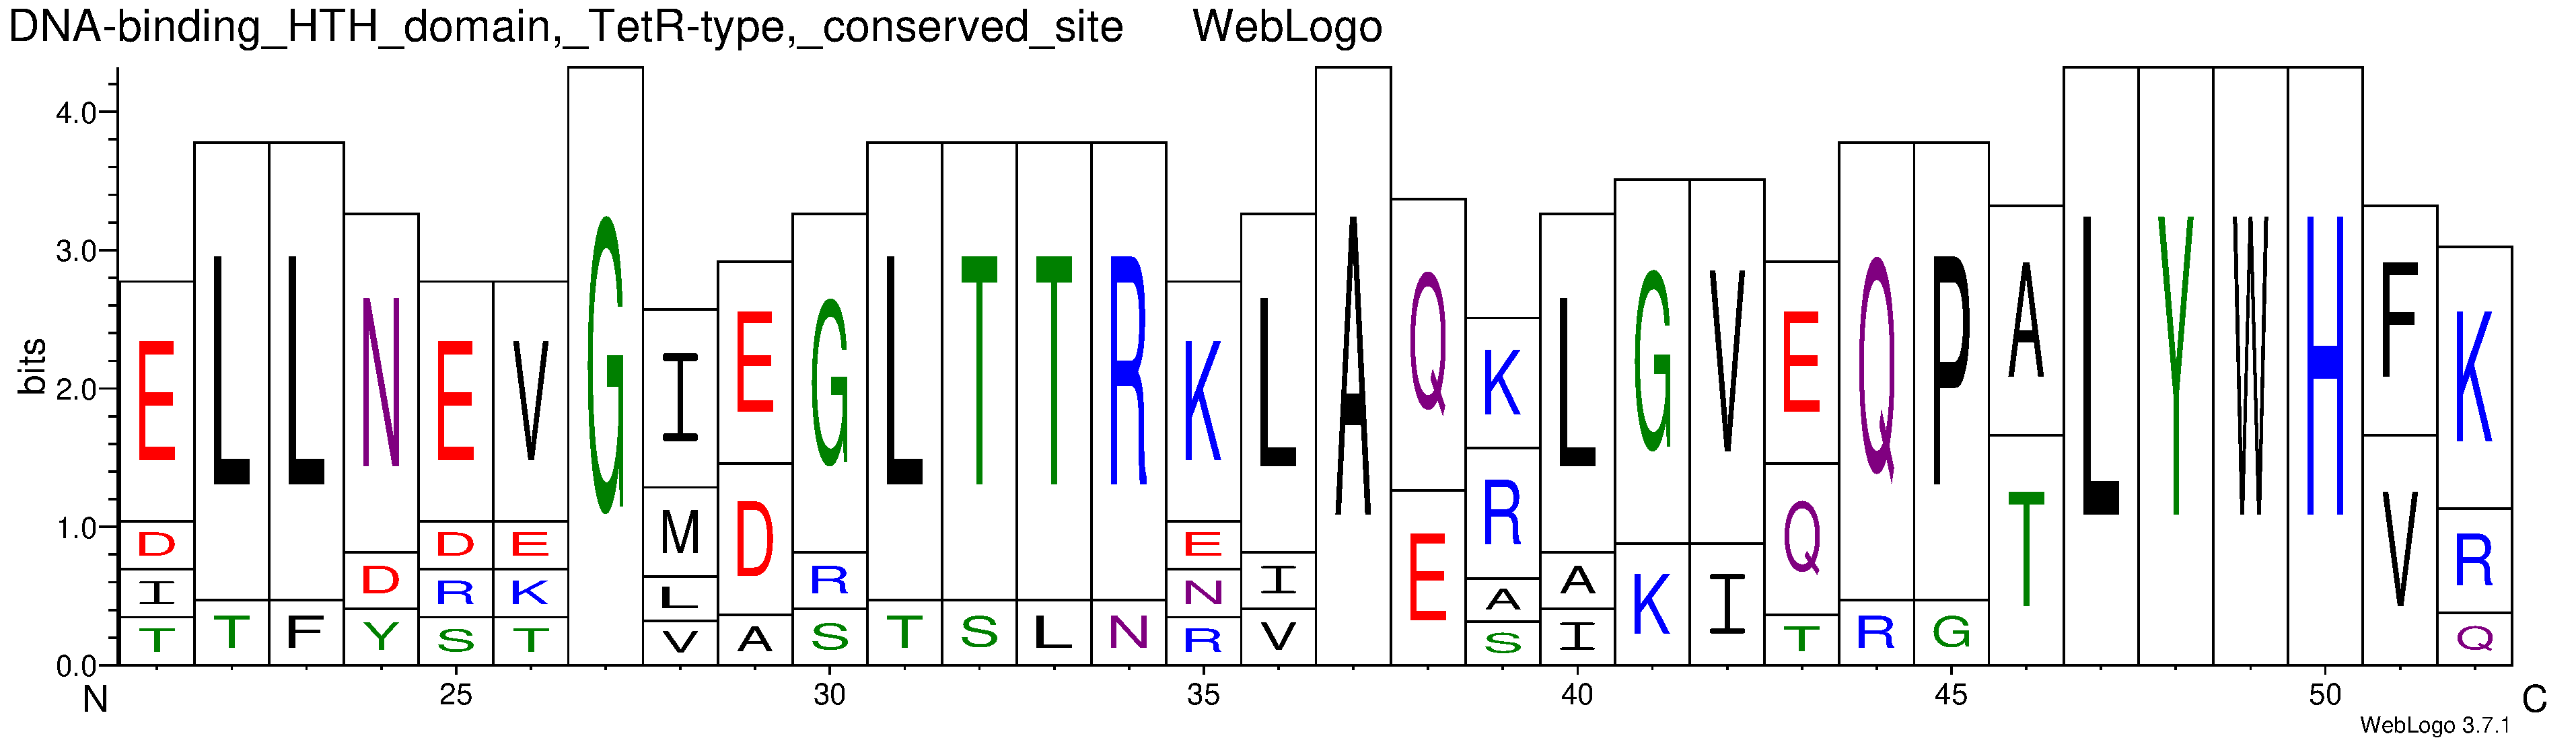

## Calcul de l'entropie
Deux procédés existent dans ce programme pour calculer l'entropie.
1. en excluant les gap
2. en considérant les gap comme des acides aminées
#### Procédé 1 avec pyproteins

In [17]:
oMsa = msaLib.Msa(fileName=P04483.clustalFile)
oMsa.entropyS

[0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.2130075659799042,
 0.9743147528693494,
 0.37677016125643675,
 1.4941751382893085,
 1.2130075659799042,
 1.3862943611198906,
 1.9061547465398496,
 0.37677016125643675,
 0.37677016125643675,
 1.7328679513998633,
 1.3862943611198906,
 0.37677016125643675,
 -0.0,
 1.0735428464085233,
 0.37677016125643675,
 0.37677016125643675,
 0.7356219397587946,
 1.0735428464085233,
 1.073542846408523,
 -0.0,
 1.2130075659799042,
 0.9743147528693494,
 0.7356219397587946,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.0735428464085233,
 0.7356219397587946,
 -0.0,
 0.6615632381579821,
 1.2554823251787535,
 0.7356219397587946,
 0.5623351446188083,
 0.5623351446188083,
 0.9743147528693494,
 0.37677016125643675,
 0.37677016125643675,
 0.6931471805599453,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 0.6931471805599453,
 0.900256

#### Procédé 2

In [18]:
P04483.msa(verbose = True)
P04483.entropy

Index sequence master is 6
pos  1 is E   1 / 8 = 0.125 with height : 0.49947340752552727
pos  1 is M   7 / 8 = 0.875 with height : 3.394078880200541
			entropy = 0.37677016125643675  with height = 3.394078880200541
pos  2 is A   4 / 8 = 0.5 with height : 1.9545719313171124
pos  2 is T   2 / 8 = 0.25 with height : 0.8906425680885631
pos  2 is N   1 / 8 = 0.125 with height : 0.4128300099555341
pos  2 is S   1 / 8 = 0.125 with height : 0.3803387358667867
			entropy = 1.2130075659799042  with height = 1.9545719313171124
pos  3 is L   1 / 8 = 0.125 with height : 0.49947340752552727
pos  3 is K   4 / 8 = 0.5 with height : 1.8246068349621227
pos  3 is R   3 / 8 = 0.375 with height : 1.230526012516818
			entropy = 0.9743147528693494  with height = 1.8246068349621227
pos  4 is K   1 / 8 = 0.125 with height : 0.49947340752552727
pos  4 is L   7 / 8 = 0.875 with height : 3.394078880200541
			entropy = 0.37677016125643675  with height = 3.394078880200541
pos  5 is T   1 / 8 = 0.125 with height : 0

pos  177 is L   1 / 8 = 0.125 with height : 0.46698213343677986
pos  177 is V   1 / 8 = 0.125 with height : 0.43449085934803244
pos  177 is F   2 / 8 = 0.25 with height : 0.7823383211260717
pos  177 is Q   1 / 8 = 0.125 with height : 0.3586778864742884
pos  177 is M   2 / 8 = 0.25 with height : 0.6307123753785836
			entropy = 1.7328679513998633  with height = 0.7823383211260717
pos  178 is F   1 / 8 = 0.125 with height : 0.49947340752552727
pos  178 is E   1 / 8 = 0.125 with height : 0.46698213343677986
pos  178 is Y   1 / 8 = 0.125 with height : 0.43449085934803244
pos  178 is D   4 / 8 = 0.5 with height : 1.5646766422521434
pos  178 is A   1 / 8 = 0.125 with height : 0.3586778864742884
			entropy = 1.3862943611198906  with height = 1.5646766422521434
pos  179 is S   3 / 8 = 0.375 with height : 1.45796493113805
pos  179 is T   1 / 8 = 0.125 with height : 0.4534970362906026
pos  179 is E   2 / 8 = 0.25 with height : 0.8203506750112121
pos  179 is R   1 / 8 = 0.125 with height : 0.37768

[0.37677016125643675,
 1.2130075659799042,
 0.9743147528693494,
 0.37677016125643675,
 1.4941751382893085,
 1.2130075659799042,
 1.3862943611198906,
 1.9061547465398496,
 0.37677016125643675,
 0.37677016125643675,
 1.7328679513998633,
 1.3862943611198906,
 0.37677016125643675,
 0.0,
 1.0735428464085233,
 0.37677016125643675,
 0.37677016125643675,
 0.7356219397587946,
 1.0735428464085233,
 1.0735428464085233,
 0.0,
 1.2130075659799042,
 0.9743147528693494,
 0.7356219397587946,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 0.37677016125643675,
 1.0735428464085233,
 0.7356219397587946,
 0.0,
 0.6615632381579821,
 1.2554823251787535,
 0.7356219397587946,
 0.5623351446188083,
 0.5623351446188083,
 0.9743147528693494,
 0.37677016125643675,
 0.37677016125643675,
 0.6931471805599453,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6931471805599453,
 0.9002560512685369,
 0.0,
 0.0,
 0.7356219397587946,
 0.7356219397587946,
 0.0,
 0.7356219397587946,
 0.37677016125643675,
 0.37677016125643675,
 

##### Représentation graphique

In [19]:
#Paramètre d'affichage
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


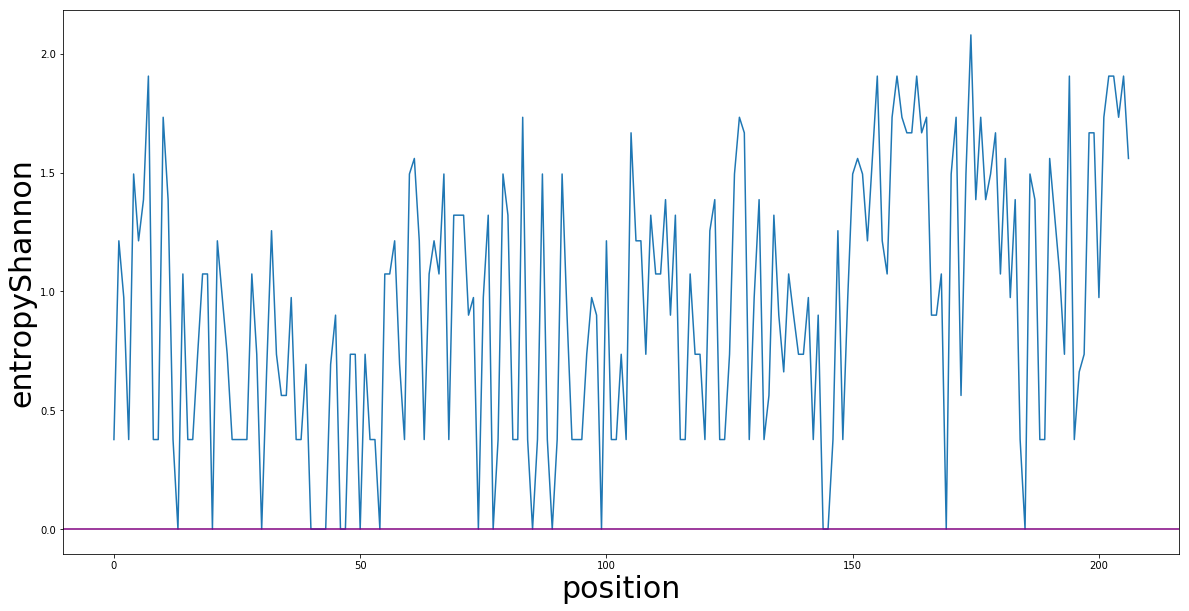

In [20]:
plt.plot(P04483.entropy)
plt.ylabel('entropyShannon', fontsize=30)
plt.xlabel('position', fontsize=30)
axhline(0, color='purple')
plt.show()

## Chiméra

```
echo "select ~#0:tdc & #0:tdc za<5 “ > chimera_command.cmd
echo "writesel my_selection.txt namingStyle simple “ >> chimera_command.cmd
chimera --nogui 2vkv.pdb1.gz chimera_command.cmd
```

`select ~#0:tdc & #0:tdc za<5`  
Sélection des atomes et/surfaces dans le modèle 0. Ici tout ce qui n’est pas de la tétracycline et tout ce qui est à moins de 5 Å.
https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/midas/select.html

`writesel my_selection.txt namingStyle simple`  
Écrit un fichier parsable de la sélection. L'option simple permet décrire : residue name, residue specifier, and atom name https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/framecommand.html

### Parser PDB
Enregistrement des chemins vers les fichiers à analyser.

In [21]:
fileTXT = "/home/antoine/Documents/Stage2019/Stage/chimeraTet_selection.txt"
filePDB = "/home/antoine/Documents/Stage2019/Stage/2vkv.pdb"

In [22]:
#PDB
p1 = {'id' : "2VKN",
    'desc' : 'seq1 PDB 2vkn',
    'seq' : "MSRLDKSKVINSALELGNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTALLQIV"
}
#UniProt
p2 = {'id' : "P08843",
    'desc' : 'seq2 P08843',
    'seq' : P04483.seq
}
#ttt
pepPDB = pep.Entry(p1)
pepUniProt = pep.Entry(p2)
#Alignement NW
blosum = scoringFunctions.Needle().fScore
nw = N.nw(gapOpen=-10, gapExtend=-0.5, matchScorer=blosum)
aliResObj = nw.align(pepPDB, pepUniProt)
print(aliResObj)

#Pour visualiser les matrices de scores du NW :
#N.viewer(aliResObj)

#Alignment score 708.0, identity(%) = 67.79, similarity(%) = 77.4
>2VKN
MSRLDKSKVINSALELGNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTALLQIV
MSRLDKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESGS-
>P08843



Parser de fichier PDB.

Retourne un dictionnaire avec en clef les chaîne de la protéine.

In [23]:
parser = PDB.Parser()
pdbObj = parser.load(file=filePDB)
pdbObj.SEQRES

{'A': 'MSRLDKSKVINSALELGNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAVEILARHHDYSLPAAGESWQSFLRNNAMSFRRALLRYRDGAKVHLGTRPDEKQYDTVETQLRFMTENGFSLRDGLYAISAVSHFTLGAVLEQQEHTAALTDRPAAPDENLPPLLREALQIMDSDDGEQAFLHGLESLIRGFEVQLTALLQIV'}

Pour récupérer une liste de tuples des AA avec leur position dans la protéine (PDB)

In [24]:
AApdb = [(pep.threeToOne(aa.name), int(aa.num)) for aa in pdbObj.byres()]

Parser de fichiers Chimera

In [25]:
f = open(fileTXT, 'r')
AAchimera = []
for line in f.readlines():
    elements = re.search('^#0.1.(?!.*HOH|.*MG).*',line)
    if elements:
        m = elements.string.split(" ")
        AAchimera.append((pep.threeToOne(m[1]), int(m[2].strip().split(".")[0])))
        #print(m[1]+" at "+str(pos[0]))
print(AAchimera)

[('L', 60), ('H', 64), ('S', 67), ('N', 82), ('F', 86), ('H', 100), ('T', 103), ('R', 104), ('P', 105), ('Q', 109), ('T', 112), ('V', 113), ('Q', 116), ('L', 117), ('L', 131), ('I', 134), ('V', 137), ('S', 138), ('L', 170), ('A', 173), ('L', 174), ('M', 177)]


Création d’un dictionnaire contenant les AA pour chaque position (clef), AA de la séquence Uniprot puis, s’ils existent du fichier PDB et de la séquence issu de chiméra.

NB1 : les AA de PDB seront eregistré s en minuscule dans le dictionnaire.  
NB2 : Attention numérotation informatique pour Uniprot mais numérotation naturelle pour les pdb

In [26]:
d = {}
for pos, aa in enumerate(P04483.seq):
    if pos not in d:
        d[pos] = [aa]
for aa1, pos1 in AApdb:
    d[pos1-1].append(aa1.lower())
for aa2, pos2 in AAchimera:
    d[pos2-1].append(aa2)
print(d)

{0: ['M'], 1: ['S'], 2: ['R'], 3: ['L'], 4: ['D'], 5: ['K', 'k'], 6: ['S', 's'], 7: ['K', 'k'], 8: ['V', 'v'], 9: ['I', 'i'], 10: ['N', 'n'], 11: ['S', 's'], 12: ['A', 'a'], 13: ['L', 'l'], 14: ['E', 'e'], 15: ['L', 'l'], 16: ['L', 'g'], 17: ['N', 'n'], 18: ['E', 'e'], 19: ['V', 'v'], 20: ['G', 'g'], 21: ['I', 'i'], 22: ['E', 'e'], 23: ['G', 'g'], 24: ['L', 'l'], 25: ['T', 't'], 26: ['T', 't'], 27: ['R', 'r'], 28: ['K', 'k'], 29: ['L', 'l'], 30: ['A', 'a'], 31: ['Q', 'q'], 32: ['K', 'k'], 33: ['L', 'l'], 34: ['G', 'g'], 35: ['V', 'v'], 36: ['E', 'e'], 37: ['Q', 'q'], 38: ['P', 'p'], 39: ['T', 't'], 40: ['L', 'l'], 41: ['Y', 'y'], 42: ['W', 'w'], 43: ['H', 'h'], 44: ['V', 'v'], 45: ['K', 'k'], 46: ['N', 'n'], 47: ['K', 'k'], 48: ['R', 'r'], 49: ['A', 'a'], 50: ['L', 'l'], 51: ['L', 'l'], 52: ['D', 'd'], 53: ['A', 'a'], 54: ['L', 'l'], 55: ['A', 'a'], 56: ['I', 'v'], 57: ['E', 'e'], 58: ['M', 'i'], 59: ['L', 'l', 'L'], 60: ['D', 'a'], 61: ['R', 'r'], 62: ['H', 'h'], 63: ['H', 'h', 'H'], 

Code pour afficher les correspondance entre les séquence d’Uniprot, PDB et Chiméra.

Utilisation du dictionnaire précédememnt créé.

In [27]:
result = {"red":[], "green":[], "yellow":[], "blue":[]}

for pos in d:
    #len 1
    if len(d[pos]) == 1:
        text = d[pos][0].lower()
    #len 2
    elif len(d[pos]) == 2:
        if compar (d[pos][0], d[pos][1]):
            if d[pos][1].isupper():
                text = colored(d[pos][0], 'white', 'on_green')
                result["green"].append((d[pos][0],pos))
            else:
                text = colored(d[pos][0], 'grey', 'on_yellow')
                result["yellow"].append((d[pos][0],pos))
        else:
            text = colored(d[pos][0], 'grey', 'on_red')
            result["red"].append((d[pos][0],pos))
    #len 3
    elif len(d[pos]) == 3:
        #3 match
        if compar(d[pos][0], d[pos][1], d[pos][2]):
            #le [2] est chimera
            text = colored(d[pos][0], 'grey', 'on_green')
            result["green"].append((d[pos][0],pos))
        #2 match
        #PDB & Uniprot
        elif compar(d[pos][0], d[pos][1]):
            if d[pos][1].islower():
                text = colored(d[pos][0], 'grey', 'on_yellow')
                result["yellow"].append((d[pos][0],pos))
            else:
                text = colored(d[pos][0], 'grey', 'on_green')
                result["green"].append((d[pos][0],pos))
        #chimera & Uniprot
        elif compar(d[pos][0], d[pos][2]):
            text = colored(d[pos][0], 'grey', 'on_green')
            result["green"].append((d[pos][0],pos))
        #chimera & PDB
        elif compar(d[pos][1], d[pos][2]):
            text = colored(d[pos][0], 'grey', 'on_blue')
            result["blue"].append((d[pos][0],pos))
        #NO match
        else:
            text = colored(d[pos][0], 'white', 'on_red')
            result["red"].append((d[pos][0],pos))
    print(text, end='')
legende()
print(result["green"])
print(result["blue"])

msrldKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESgs

    perfect Match
    PDB Match
    PDB & Chimera Match, no UniProt
    No Match
[('L', 59), ('H', 63), ('N', 81), ('F', 85), ('H', 99), ('T', 102), ('R', 103), ('P', 104), ('Q', 108), ('T', 111), ('Q', 115), ('L', 116), ('L', 130), ('V', 136), ('L', 169), ('A', 172)]
[('F', 66), ('L', 112), ('L', 133), ('G', 137), ('I', 173), ('F', 176)]


### Graphiques

Graphique pour visualiser la conservation (entropie) au sein d’un domaine.


Le domaine peut-être choisi parmi la liste des domaines issus du scan.
Attention, les points qui s’affichent sur le graphique sont issus depuis le dictionnaire contenant les résultats de correspondances entre les séquences. Le choix des points se fait en fonction de « leur couleur ».


NB : code couleur identique que lors de la correspondance entre les séquences.

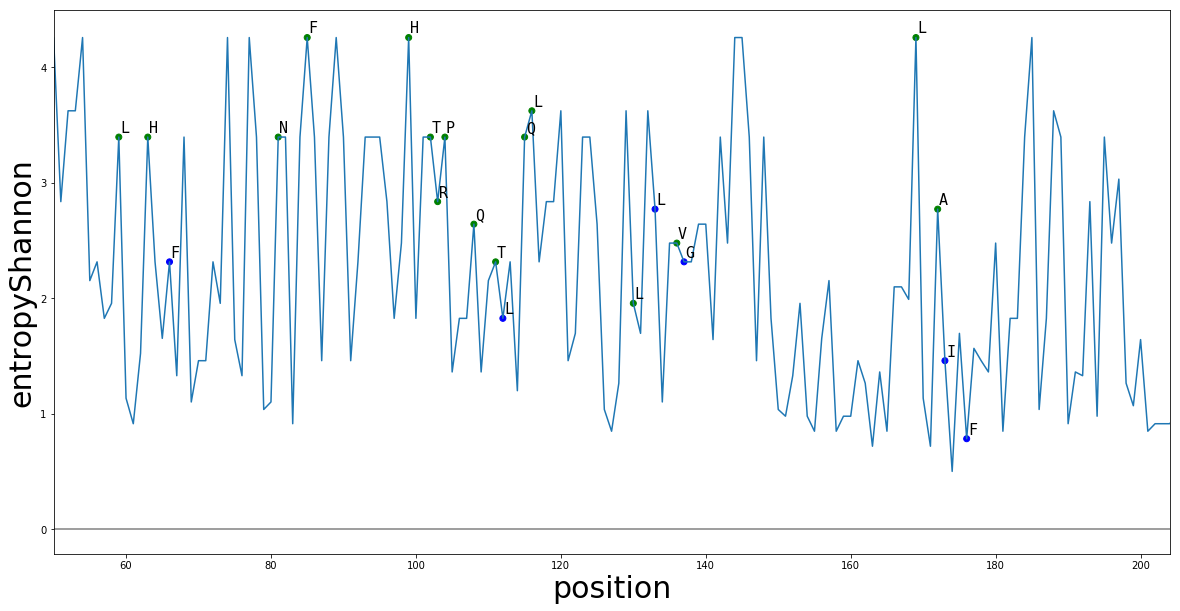

In [28]:
#entropie = P04483.entropy[int(interval[0]):int(interval[1])]
#entropie = P04483.entropy
entropie = P04483.entropyHeight
plt.plot(entropie)
interval = P04483.domains['Tetracyclin repressor-like, C-terminal domain superfamily']['interval'][0]
#interval = (0,len(entropie))
plt.xlim(50,int(interval[1])) #????
#plt.xlim(int(interval[0]),int(interval[1]))
#plt.xlim(30,80)
colors = []
AAlist = []
xy = {"x": [] , "y" : []}

"""for pos,i in enumerate(entropie):
    if i == 0:
        AA = P04483.seq[pos-int(interval[0])]
        xy["x"].append(pos)
        xy ["y"].append(0)
        colors.append('magenta')
        plt.text(pos, 0, AA, fontsize=12, position=(pos-0.5, entropie[pos]-0.07), fontname='monospace', color = 'grey')
    else:
        AA = P04483.seq[pos-int(interval[0])]
        xy = (pos, entropie[pos])
        plt.plot(xy[0], xy[1])
        plt.annotate(AA, xy=xy, textcoords='data', fontsize=15)"""
        
for color in result:
    if color in ["green", "blue"]:
        duo = result[color]
        for aa, pos in duo:
            xy["x"].append(pos)
            xy ["y"].append(entropie[pos])
            colors.append(color)
            plt.text(pos, entropie[pos], aa, fontsize=15, position=(pos+0.15, entropie[pos]+0.04), fontname='monospace')
plt.scatter("x","y", data=xy, c=colors)
plt.ylabel('entropyShannon', fontsize=30)
plt.xlabel('position', fontsize=30)
axhline(0, color='grey')
plt.show()

### Statistiques de conservations des domaines
Doit être lancé après les parser de PDB et de Chiméra

In [29]:
#Intersec Uniprot seq vs PDB + select Chimera
dicolo = intersection(P04483.seq, "/home/antoine/Documents/Stage2019/Stage/2vkv.pdb",
                      "/home/antoine/Documents/Stage2019/Stage/chimeraDimer_selection.txt", verbose=False)

msrldKSKVINSALELLNEVGIEGLTTRKLAQKLGVEQPTLYWHVKNKRALLDALAIEMLDRHHTHFCPLEGESWQDFLRNNAKSFRCALLSHRDGAKVHLGTRPTEKQYETLENQLAFLCQQGFSLENALYALSAVGHFTLGCVLEDQEHQVAKEERETPTTDSMPPLLRQAIELFDHQGAEPAFLFGLELIICGLEKQLKCESgs

    perfect Match
    PDB Match
    PDB & Chimera Match, no UniProt
    No Match


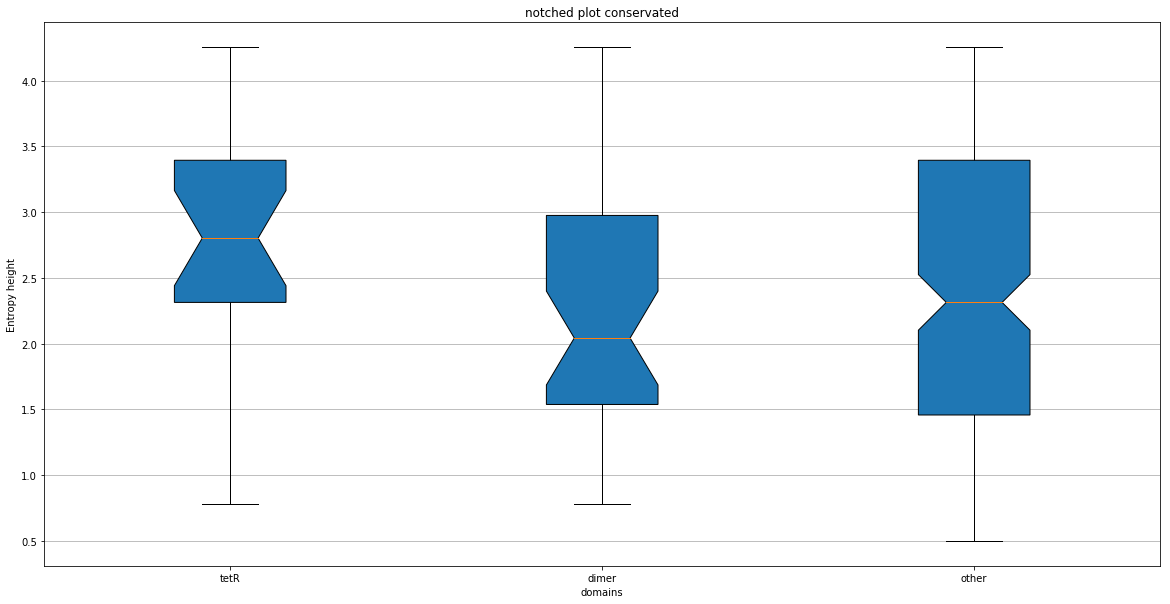

In [30]:
tetR = []
dimer = []
other = []

for color in result:
    if color in ["green", "blue"]:
        duo = result[color]
        for aa, pos in duo:
            tetR.append(P04483.entropyHeight[pos])
for color in dicolo:
    if color in ["green", "blue"]:
        duo = dicolo[color]
        for aa, pos in duo:
            dimer.append(P04483.entropyHeight[pos])

for i in range(0, len(P04483.seq)):
    if i not in tetR or not i in dimer:
        other.append(P04483.entropyHeight[i])
        
data = [tetR, dimer, other]

fig, ax = plt.subplots()
ax.set_title('notched plot conservated')
labels = ['tetR', 'dimer', 'other']
ax.boxplot(data,
        notch=True,  # notch shape
        vert=True,  # vertical box alignment
        patch_artist=True,  # fill with color
        labels=labels)  # will be used to label x-ticks
ax.yaxis.grid(True)
ax.set_xlabel('domains')
ax.set_ylabel('Entropy height')
plt.show()

# Références
1.tetR - Tetracycline repressor protein class B from transposon Tn10 - Escherichia coli - tetR gene & protein. Available at: https://www.uniprot.org/uniprot/P04483. (Accessed: 15th March 2019)

**Stage** : *mmsb février à avril 2019*  
**Stagiaire** : [*Antoine Heurtel*](https://fr.linkedin.com/in/antoine-heurtel-lyon), follow me on [GitHub](https://github.com/AntoineHeurtel)  
**Mail** : *(antoine.heurtel@gmail.com)*